This script demonstrates the use of FLAML AutoML to train a baseline regression model using different fraction of the fine-tuning training dataset. The baseline model's predictions are then compared with the fine-tuned model's results on the MEGAPOLI Marine test dataset.

Key steps include:

1. **Data Preprocessing**:
   - Cleaning and preparing the training dataset by removing missing values.
   - Extracting features and target variables for training and testing.

2. **Model Training with AutoML**:
   - Setting a time budget and configuring model evaluation using cross-validation.
   - Automatically selecting the best model and hyperparameters from a list of estimators.

3. **Evaluation**:
   - Using the trained AutoML model to make predictions on the test dataset.
   - Calculating evaluation metrics: R², RMSE, MAE, and MAPE.

4. **Visualization**:
   - Plotting actual vs. predicted values over time for better interpretability.

5. **Comparison**:
   - The trained baseline model serves as a reference for comparing its performance against 
     a fine-tuned model.

This process enables efficient model benchmarking and evaluation in aerosol research applications.

In [1]:
import pandas as pd
import numpy as np
import json
import time
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import joblib
import sys
import matplotlib.pyplot as plt


c:\Users\1\miniconda3\envs\partmc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Number of parallel jobs (e.g., for model training)
n_jobs = int(8)

# Load the training dataset
df_train = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')

# Drop rows with missing values to ensure clean data
df_train = df_train.dropna()

input_list = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ppb)', 'OA (ppb)', 'NH4 (ppb)', 'NO3 (ppb)', 'SO4 (ppb)']

# Set log file, model file, and output file names
log_file_name = "../Model/AutoML_0%Data"+".log"
model_file_name = "../Model/AutoML_0%Data" + ".pkl"
output_file = "../Model/AutoML_0%Data"+".csv"

# Extract chi value for training
output_list = df_train.columns[23]

# Extract input features and target variable for training
X_train = df_train[input_list]
y_train = df_train[output_list]



In [ ]:
# setup for automl
automl = AutoML()

# Set the time budget for AutoML (in seconds)
time_budget =5

# Specify automl goal and constraint
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'mse',   # Time budget for the entire AutoML process
    "task": 'regression',   # Task type (regression in this case)
    "eval_method" : "cv",   # Cross-validation for model evaluation
    "n_splits":5,           # Number of folds in cross-validation
    "estimator_list": [
        "lgbm",
        "xgboost",
        "rf",
        "extra_tree",
    ],
    "n_jobs": n_jobs,
    "log_file_name": log_file_name,
}

# Train the AutoML model with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

# Print the best model selected by AutoML
print(automl.model.estimator)

# Save the best model selected by AutoML
best_model = automl.model.estimator
joblib.dump(best_model, model_file_name)


[flaml.automl.logger: 01-30 17:00:46] {1680} INFO - task = regression
[flaml.automl.logger: 01-30 17:00:46] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 17:00:46] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 01-30 17:00:46] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 01-30 17:00:46] {2219} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 01-30 17:00:49] {2345} INFO - Estimated sufficient time budget=19647s. Estimated necessary time budget=20s.
[flaml.automl.logger: 01-30 17:00:49] {2392} INFO -  at 2.1s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 01-30 17:00:49] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-30 17:00:50] {2392} INFO -  at 3.3s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl.logger: 01-30 17:00:50] {2219} INFO - iteration 2, current learner xgboost


TypeError: fit() got an unexpected keyword argument 'callbacks'

In [3]:
def calculate_metrics_and_plot(y_true, y_pred, time_column):
    """
    Calculate evaluation metrics and plot actual vs. predicted values over time.

    Parameters:
    - y_true: Actual target values
    - y_pred: Predicted target values
    - time_column: Corresponding time column for the x-axis

    Returns:
    - Tuple of calculated metrics (R2, RMSE, MAE, MAPE)
    """

    # Calculate evaluation metrics
    r2 = r2_score(y_true, y_pred)  # R-squared
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Root Mean Squared Error
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Print the calculated metrics
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_column, y_true, label='Actual', color='blue')  # Actual values in blue
    plt.plot(time_column, y_pred, label='Predicted', color='red')  # Predicted values in red
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()

    # Return the calculated metrics
    return r2, rmse, mae, mape


c:\Users\1\miniconda3\envs\partmc\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\1\miniconda3\envs\partmc\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreesRegressor from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\1\miniconda3\envs\partmc\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculat

R2: 0.19147220895163086
RMSE: 0.05921532770665279
MAE: 0.04906487604746759
MAPE: 9.432677436224521


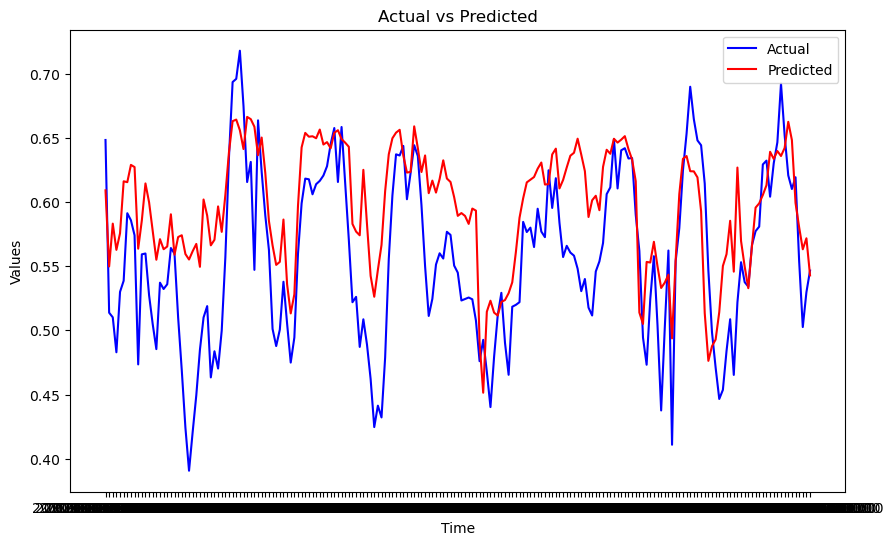

(0.19147220895163086,
 0.05921532770665279,
 0.04906487604746759,
 9.432677436224521)

In [4]:
model_file_name = '../Model/AutoML_50%Data.pkl'
automl = joblib.load(model_file_name)


# Load the test dataset
df_test = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv')

# Extract features and target variable from the test dataset
X_test = df_test[input_list]
y_test = df_test[output_list]

# Make predictions using the AutoML model
y_test_pred = automl.predict(X_test)


# Save y_true and y_pred as a DataFrame
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_test_pred
})
# results_df.to_csv('/Data/Fine_tuned_Results_different_data_size/AutoML_5%Data.csv', index=False)

calculate_metrics_and_plot(y_test, y_test_pred, df_test['Time'])

In [5]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(automl, X_test, y_test, scoring="neg_mean_squared_error", n_repeats=50, random_state=42, n_jobs=8)
# Convert results to DataFrame
importance_df = pd.DataFrame({
    "Feature": input_list,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

importance_df


,Feature,Importance
14,OA (ppb),0.003066
0,O3 (ppb),0.000210
16,NO3 (ppb),0.000112
12,RH,0.000105
6,XYL (ppb),0.000087
11,Temperature(K),0.000057
15,NH4 (ppb),0.000050
7,ALD2 (ppb),0.000045
2,NO (ppb),0.000022
3,NOx (ppb),0.000013


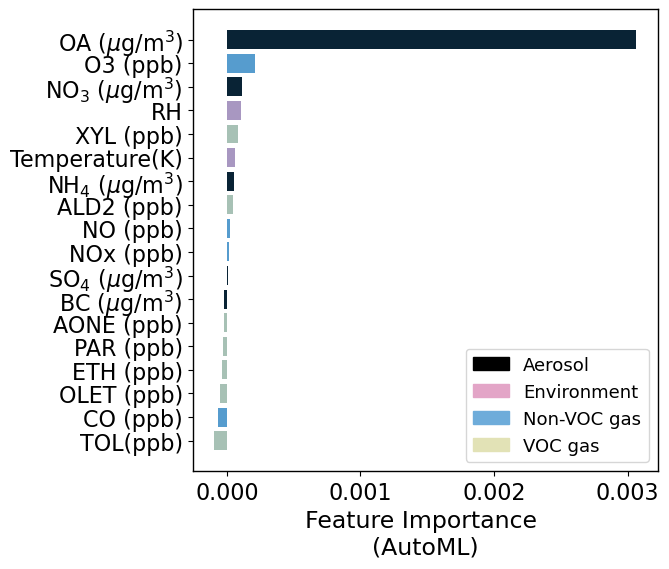

In [6]:
# Define feature categories and colors
feature_categories = {
    'Aerosol': ['BC (ppb)', 'OA (ppb)', 'NH4 (ppb)', 'NO3 (ppb)', 'SO4 (ppb)'],  
    'VOC gas': ['ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)', 'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)',],      
    'Non-VOC gas': ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)'],      
    'Environment': ['Temperature(K)', 'RH']  
}

category_colors = {
    'Aerosol': 'black',
    'Environment': '#E3A5C7',
    'Non-VOC gas': '#6EACDA',
    'VOC gas': '#E2E2B6'
}
import matplotlib.patches as mpatches

# Map feature names for display
unit_mapping = {
    'BC (ppb)': 'BC ($\mu$g/m$^3$)',
    'OA (ppb)': 'OA ($\mu$g/m$^3$)',
    'NH4 (ppb)': 'NH$_4$ ($\mu$g/m$^3$)',
    'NO3 (ppb)': 'NO$_3$ ($\mu$g/m$^3$)',
    'SO4 (ppb)': 'SO$_4$ ($\mu$g/m$^3$)'
}

display_feature_names = [unit_mapping.get(feature, feature) for feature in importance_df['Feature']]

fig, ax = plt.subplots(figsize=(6, 6)) 
plt.barh(range(len(importance_df['Importance'])), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df['Importance'])), display_feature_names)
plt.xlabel('Importance')
plt.gca().invert_yaxis()

# Assign colors to each feature
colors = []
for feature in importance_df['Feature']:
    for category, features in feature_categories.items():
        if feature in features:
            colors.append(category_colors[category])
            break
    else:
        colors.append('gray')  # Default color if the feature is not in any category

# Plot the bar chart with colors
bars = plt.barh(range(len(importance_df['Importance'])), importance_df['Importance'], align='center', color=colors, alpha=0.7)

plt.tick_params(axis='x', labelsize=16)

ax.set_yticklabels(display_feature_names, fontsize=16)
ax.set_xlabel('Feature Importance \n(AutoML)', fontsize=17)

# Add legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
ax.legend(handles=legend_patches, loc='best', fontsize=13)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
plt.savefig('Permutation_AutoML.png', dpi=400, bbox_inches='tight')

plt.show()